# K-Armed Bandits in Action

### Environment

We choose to opt for the cliched slot-machine environment where we have $K$ slot machines with $K$ arms. Each arm when pulled yields a certain reward and the goal of the agent is to maximize the average cumulative reward.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import seaborn as sns

%matplotlib inline

In [2]:
class SlotMachineEnvironment:
    def __init__(self, reward_probabilities, rewards):
        """Since this is MAB problem, we first consider the fixed reward probabilities scenario.
           The reward probabilities and rewards are passed in to the environment.
           The agent tries to learn which arms to pull to gain the maximum cumulative reward.
        """
        self.reward_probabilities = reward_probabilities
        self.rewards = rewards
        self.k_arms = len(rewards)
        
    def pull(self, arm):
        if np.random.random() < self.reward_probabilities[arm]:
            return self.rewards[arm]
        else:
            return 0.0

In [3]:
arms = 10 # consider there are 10 arms
reward_probs = [random.random() for _ in range(arms)]
rewards = [random.randint(0, 100) for _ in range(arms)]
base_environment = SlotMachineEnvironment(reward_probabilities=reward_probs, rewards=rewards)

In [4]:
class RandomAgent:
    def __init__(self, environment, steps):
        """Instantiation of a random agent.
        This takes in the environment and the maximum number of steps.
        The agent randomly selects an arm to pull without learning.
        """
        self.environment = environment
        self.steps = steps
    
    def step(self):
        count_of_arms_pulled = np.zeros(self.environment.k_arms)
        rewards_obtained = []
        cumulative_rewards = []
        
        for _ in range(self.steps):
            arm_to_pull = np.random.choice(self.environment.k_arms)
            reward = self.environment.pull(arm_to_pull)
            count_of_arms_pulled[arm_to_pull] += 1
            
            rewards_obtained.append(reward)
            cumulative_rewards.append(sum(rewards)/len(rewards))
            
        return (count_of_arms_pulled, 
                rewards_obtained, 
                cumulative_rewards)

In [5]:
random_agent = RandomAgent(environment=base_environment, steps=10000)
(ra_arms_pulled, ra_rewards_obtained, ra_cumulative_rewards) = random_agent.step()

In [6]:
class EpsilonGreedyAgent:
    def __init__(self, environment, steps, epsilon):
        """Instantiation of the epsilon greedy agent.
        This agent estimates the q-values and selects the arm to pull which has maximum q-value.
        The epsilon decides when to explore and when to exploit.
        """
        self.environment = environment
        self.steps = steps
        self.epsilon = epsilon
        
    def step(self):
        k_arms = self.environment.k_arms
        q_values = np.zeros(k_arms)
        rewards_obtained_per_arm = np.zeros(k_arms)
        count_of_arms_pulled = np.zeros(k_arms)
        
        rewards = []
        cumulative_rewards = []
        
        for _ in range(self.steps):
            if np.random.random() < self.epsilon:
                arm_to_pull = np.random.choice(k_arms) # explore
            else:
                arm_to_pull = np.argmax(q_values) # exploit
            
            reward = self.environment.pull(arm_to_pull)
            rewards_obtained_per_arm[arm_to_pull] += reward
            count_of_arms_pulled[arm_to_pull] += 1
            q_values[arm_to_pull] = rewards_obtained_per_arm[arm_to_pull]/count_of_arms_pulled[arm_to_pull]
            
            rewards.append(reward)
            cumulative_rewards.append(sum(rewards)/len(rewards))
            
        return (count_of_arms_pulled,
                rewards,
                cumulative_rewards)

In [7]:
eps_greedy_agent = EpsilonGreedyAgent(environment=base_environment, steps=10000, epsilon=0.1)
(epsg_arms_pulled, epsg_rewards_obtained, epsg_cumulative_rewards) = eps_greedy_agent.step()

In [16]:
eps_greedy_agent_2 = EpsilonGreedyAgent(environment=base_environment, steps=10000, epsilon=0.01)
(epsg_2_arms_pulled, epsg_2_rewards_obtained, epsg_2_cumulative_rewards) = eps_greedy_agent_2.step()

In [17]:
eps_greedy_agent_3 = EpsilonGreedyAgent(environment=base_environment, steps=10000, epsilon=0.001)
(epsg_3_arms_pulled, epsg_3_rewards_obtained, epsg_3_cumulative_rewards) = eps_greedy_agent_3.step()

In [10]:
class ThompsonSamplingAgent:
    def __init__(self, environment, steps):
        """Instantiation of the ThompsonSampling agent.
           The Thompson agent is a Bernoulli bandit (in this case).
           It generates a model of reward probabilities 
        """
        self.environment = environment
        self.steps = steps

    def step(self):
        k_arms = self.environment.k_arms
        count_of_arms_pulled = np.zeros(k_arms)
        rewards_obtained = np.zeros(k_arms)
        failures = np.zeros(k_arms)
        
        cumulative_rewards = []
        total_rewards = []
        
        for _ in range(self.steps):
            arm_to_pull = 0
            beta_max = 0
            for j in range(k_arms):
                beta_d = random.betavariate(rewards_obtained[j] + 1, failures[j] + 1)
                if beta_d > beta_max:
                    beta_max = beta_d
                    arm_to_pull = j
                    
            count_of_arms_pulled[arm_to_pull] += 1
            reward = self.environment.pull(arm_to_pull)
            if reward > 90: # modification to allow for Bernoulli Bandit
                rewards_obtained[arm_to_pull] += 1 # alpha
            else:
                failures[arm_to_pull] += 1 # beta
            
            total_rewards.append(reward)
            cumulative_rewards.append(sum(total_rewards)/len(total_rewards))
            
        return (count_of_arms_pulled, 
                rewards_obtained, 
                cumulative_rewards)

In [11]:
thompson_sampling_agent = ThompsonSamplingAgent(environment=base_environment, steps=10000)
(ths_arms_pulled, ths_rewards_obtained, ths_cumulative_rewards) = thompson_sampling_agent.step()

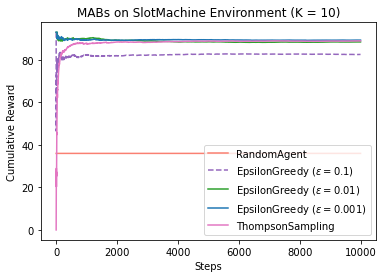

In [18]:
# plots
plt.plot(ra_cumulative_rewards, label='RandomAgent', color='salmon')
plt.plot(epsg_cumulative_rewards, label='EpsilonGreedy ($\epsilon=0.1$)', color='tab:purple', linestyle='--')
plt.plot(epsg_2_cumulative_rewards, label='EpsilonGreedy ($\epsilon=0.01$)', color='tab:green')
plt.plot(epsg_3_cumulative_rewards, label='EpsilonGreedy ($\epsilon=0.001$)', color='tab:blue')
plt.plot(ths_cumulative_rewards, label='ThompsonSampling', color='tab:pink')
plt.title('MABs on SlotMachine Environment (K = 10)')
plt.xlabel('Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.savefig('mab_agents_on_slotenv.pdf', dpi=300, bbox_inches='tight')
plt.show()